#                            Credit Score Notebook 

In [1]:
#Importing libraries
import seaborn as sns 
import matplotlib.pyplot as plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Libraries imported successfully....")

Libraries imported successfully....


In [2]:
#Import data
df =  pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Data imported successfully....")

C:\Users\User\AppData\Local\Temp\ipykernel_7708\2737514486.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df =  pd.read_csv('train.csv')


Data imported successfully....


In [3]:
df.drop('Payment_Behaviour', axis=1)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,3.0,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,479.866228,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,3.0,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,496.65161,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,3.0,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,516.809083,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,3.0,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,319.164979,Standard


In [4]:
# get the number of missing data points per column in Complaints_df
missing_values_count = df.isnull().sum()

# look at the # of missing points
missing_values_count

##Relevant Null vallues dropped in mining via query. 

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [5]:
df.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

##### Missing data handling plan
1. Name: We wont be using this as a feature 
2. Monthly inhand salary,Number of delayed payment, Num credit inquiries, Amount invested monthly, Monthly balance : all set to zero.
3. Type of Loan: will be split into one hot and null values will sort theselves out.
4. Credit history age will be feature engineered into numerics and null will be set to zero

There is data for eight months of the year for each client. Upon research, I found that credit score is not dependant on the previous month hence each entry in the dataset can and will be used independently. Trying a time series trick would be overfitting.


#### Numeric values handling

In [6]:
#Credit history age to months
def age_to_months(age_str):
    if pd.isna(age_str) or age_str == '':
        return float('nan')
    age_list = age_str.split()
    years = int(age_list[0])
    months = int(age_list[3])
    total_months = years * 12 + months
    return total_months

df['Credit_History_Age'] = df['Credit_History_Age'].apply(age_to_months)

numeric_cols = ['Annual_Income','Monthly_Inhand_Salary','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Num_of_Loan','Delay_from_due_date','Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries','Outstanding_Debt','Credit_Utilization_Ratio','Credit_History_Age','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance']
categorical_cols = ['Occupation','Credit_Mix','Payment_of_Min_Amount']


#Cleaning up underscored columns

# remove '_' from values in specified columns and convert to float
numeric_cols

['Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Credit_History_Age',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Monthly_Balance']

In [7]:
for col in numeric_cols:
    df[col] = df[col].replace('_', '')
    df[col] = pd.to_numeric(df[col], errors='coerce')

# print the updated DataFrame
print(df)

            ID Customer_ID     Month           Name   Age          SSN  \
0       0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265   
1       0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265   
2       0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265   
3       0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265   
4       0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265   
...        ...         ...       ...            ...   ...          ...   
99995  0x25fe9  CUS_0x942c     April          Nicks    25  078-73-5990   
99996  0x25fea  CUS_0x942c       May          Nicks    25  078-73-5990   
99997  0x25feb  CUS_0x942c      June          Nicks    25  078-73-5990   
99998  0x25fec  CUS_0x942c      July          Nicks    25  078-73-5990   
99999  0x25fed  CUS_0x942c    August          Nicks    25  078-73-5990   

      Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0      Scientist       19114.12   

 #### Categorical values handling

1. Segregate into high paying, medium and low paying' and use ordinal encoding
2. Month to be transformed into ordinal encoding
3. Separate types of loans and Payment_Behaviour by commas and count number of loans
4. Transform Credit Mix and Payment_of_Min_Amount with ordinal encoding


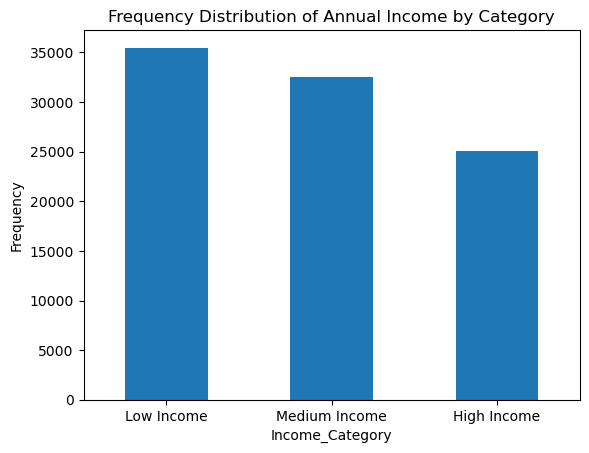

In [8]:
#Annual salaries feature engineering

# Define the income thresholds for each category
income_bins = [0, 30000, 70000, float('inf')]
income_labels = ['Low Income', 'Medium Income', 'High Income']

# Segregate the annual income into categories using pandas cut() function
df['Income_Category'] = pd.cut(df['Annual_Income'], bins=income_bins, labels=income_labels)

# Plot the frequency distribution of each income category using a bar plot
df['Income_Category'].value_counts().plot(kind='bar', rot=0)

# Set the axis labels and title
plt.xlabel('Income_Category')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Annual Income by Category')

# Show the plot
plt.show()


In [9]:
df.loc[:,['Month','Occupation','Type_of_Loan','Credit_Mix','Payment_of_Min_Amount','Payment_Behaviour','Credit_Score']]

,Month,Occupation,Type_of_Loan,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
0,January,Scientist,"Auto Loan, Credit-Builder Loan, Personal Loan,...",_,No,High_spent_Small_value_payments,Good
1,February,Scientist,"Auto Loan, Credit-Builder Loan, Personal Loan,...",Good,No,Low_spent_Large_value_payments,Good
2,March,Scientist,"Auto Loan, Credit-Builder Loan, Personal Loan,...",Good,No,Low_spent_Medium_value_payments,Good
3,April,Scientist,"Auto Loan, Credit-Builder Loan, Personal Loan,...",Good,No,Low_spent_Small_value_payments,Good
4,May,Scientist,"Auto Loan, Credit-Builder Loan, Personal Loan,...",Good,No,High_spent_Medium_value_payments,Good
...,...,...,...,...,...,...,...
99995,April,Mechanic,"Auto Loan, and Student Loan",_,No,High_spent_Large_value_payments,Poor
99996,May,Mechanic,"Auto Loan, and Student Loan",_,No,High_spent_Medium_value_payments,Poor
99997,June,Mechanic,"Auto Loan, and Student Loan",Good,No,High_spent_Large_value_payments,Poor
99998,July,Mechanic,"Auto Loan, and Student Loan",Good,No,Low_spent_Large_value_payments,Standard


In [10]:
unique_count = df['Payment_of_Min_Amount'].value_counts()
print(unique_count)

Yes    52326
No     35667
NM     12007
Name: Payment_of_Min_Amount, dtype: int64


#### Exploration

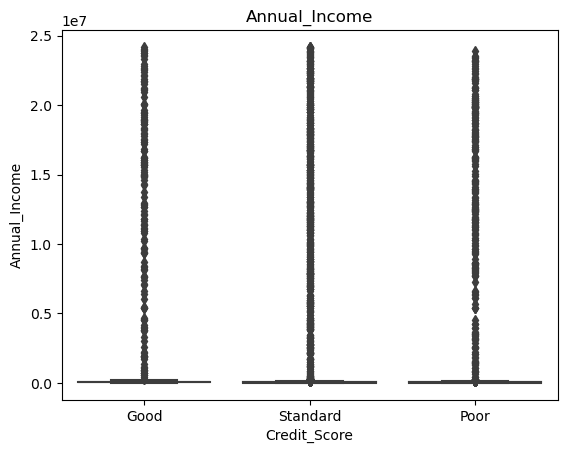

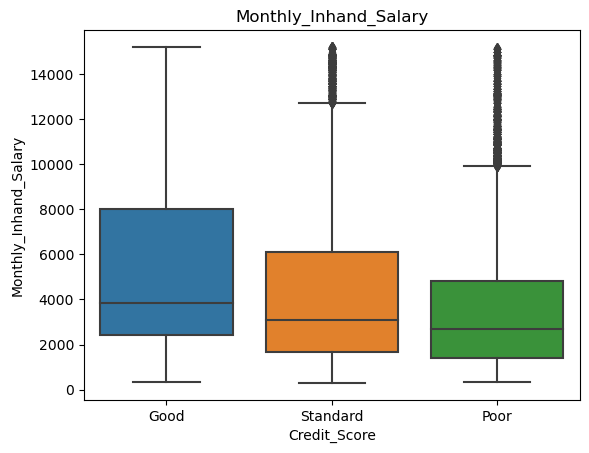

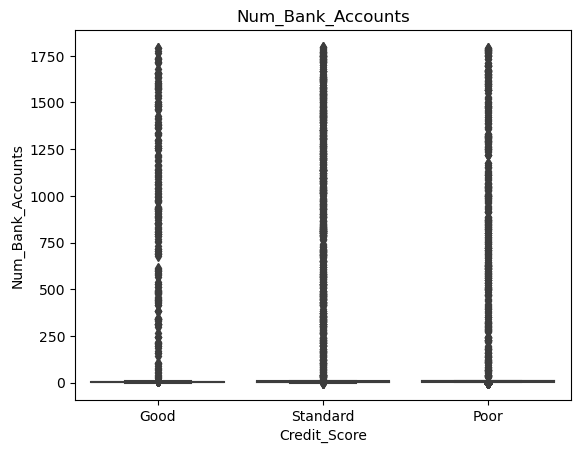

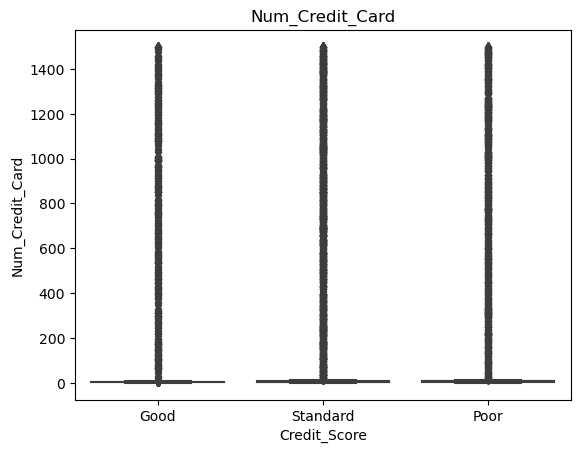

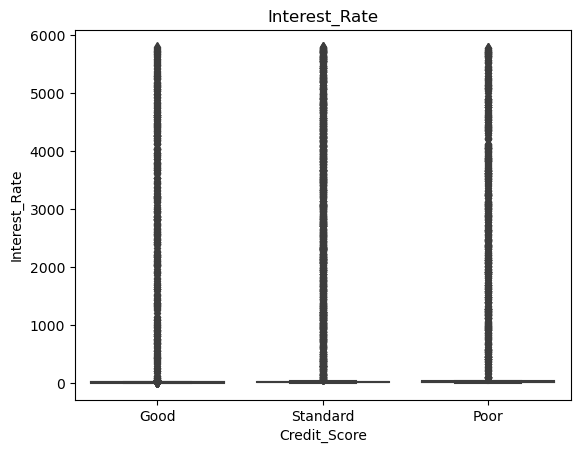

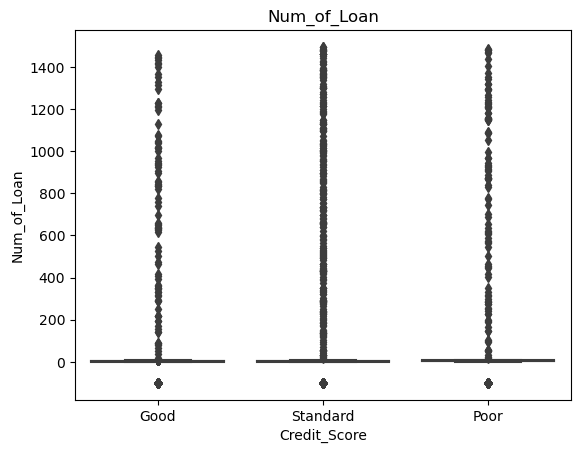

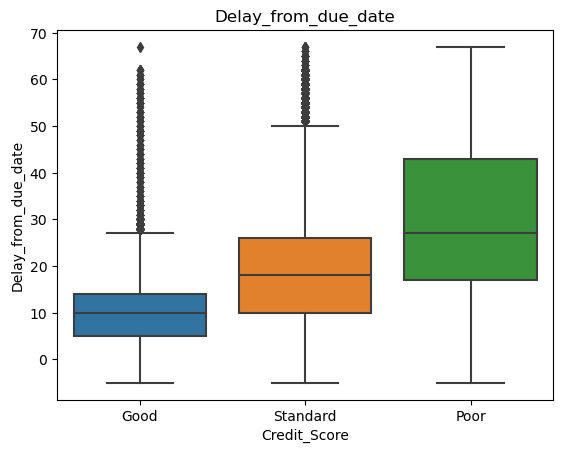

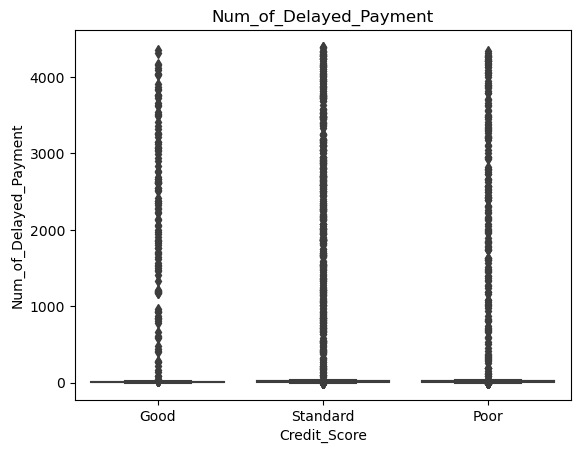

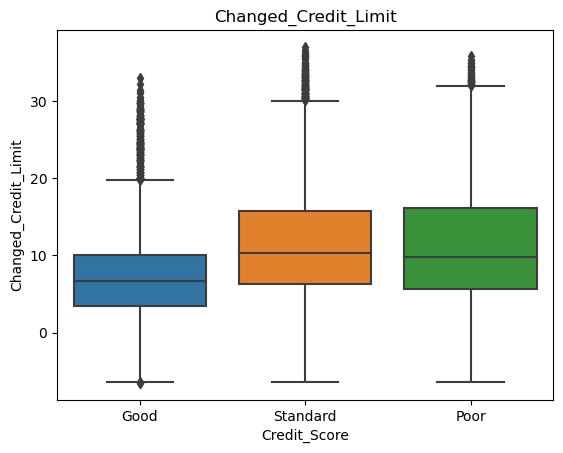

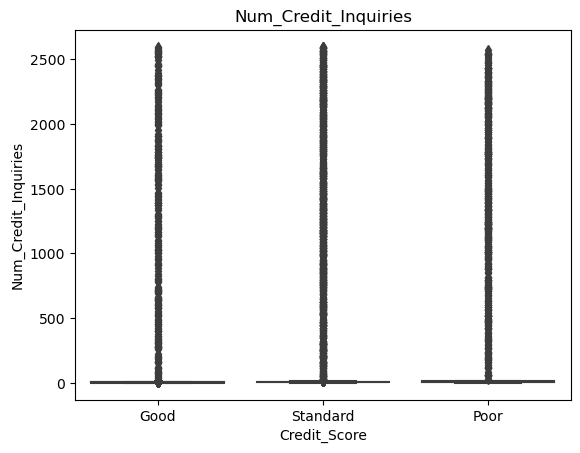

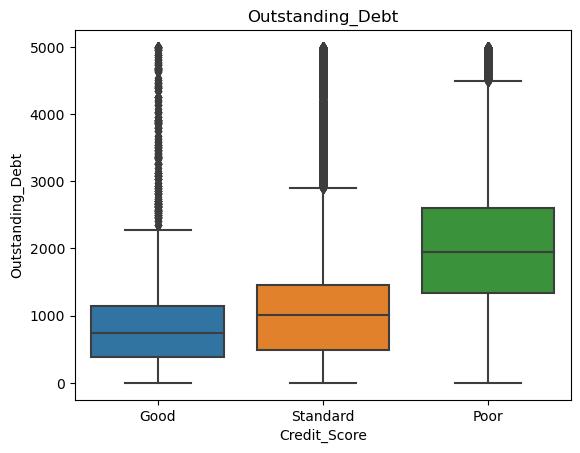

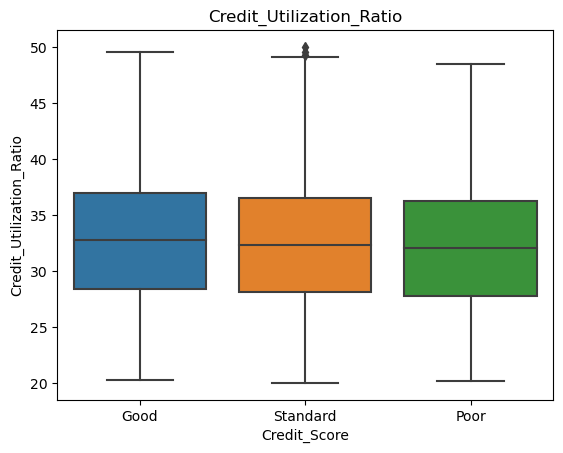

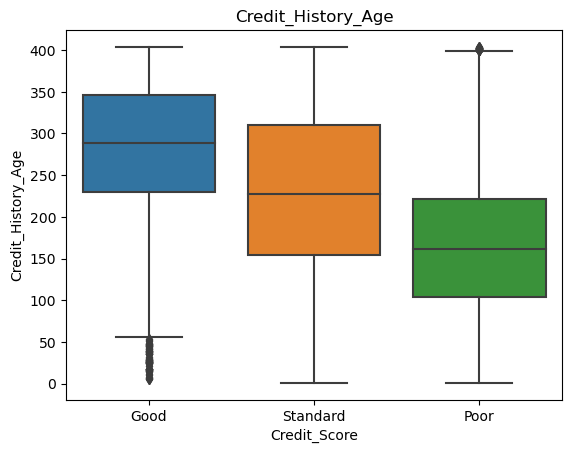

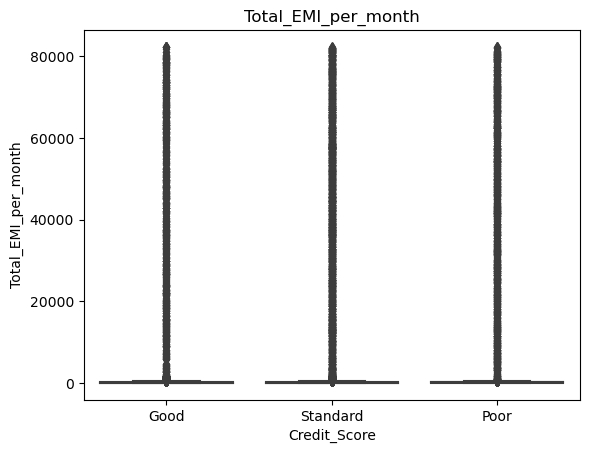

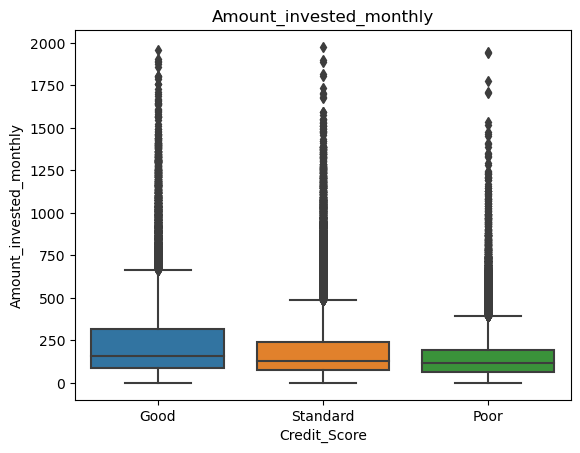

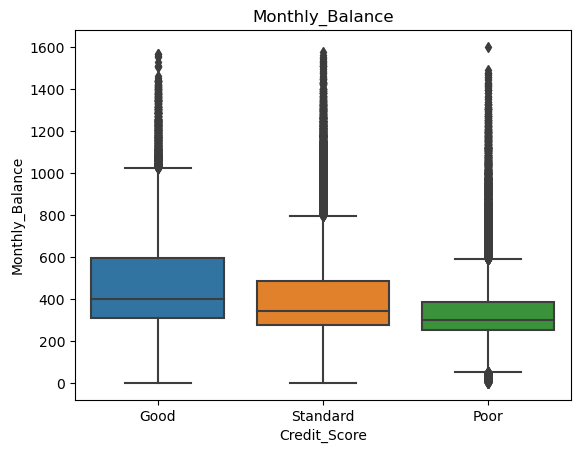

In [11]:
# Create a box plot for each numeric column by "Credit_Score"
for col in numeric_cols:
    plt.figure()
    sns.boxplot(x='Credit_Score', y=col, data=df)
    plt.title(col)
    
plt.show()


c:\Users\User\.conda\envs\NewEnv\lib\site-packages\pandas\plotting\_matplotlib\core.py:677: UserWarning: The label '_______' of <BarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)


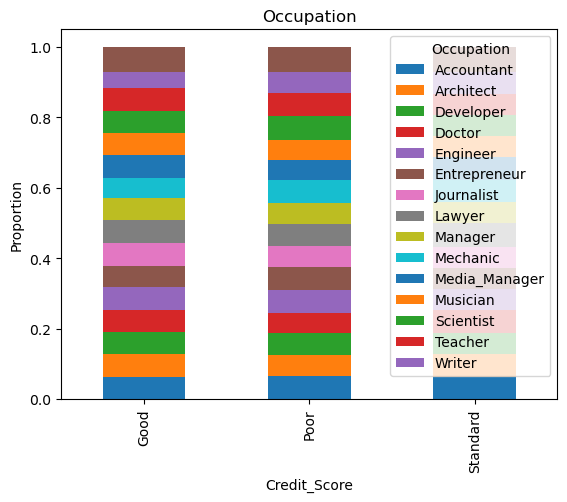

c:\Users\User\.conda\envs\NewEnv\lib\site-packages\pandas\plotting\_matplotlib\core.py:677: UserWarning: The label '_' of <BarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)


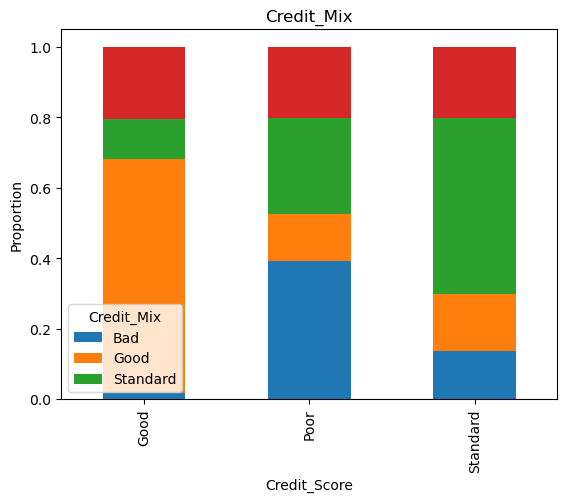

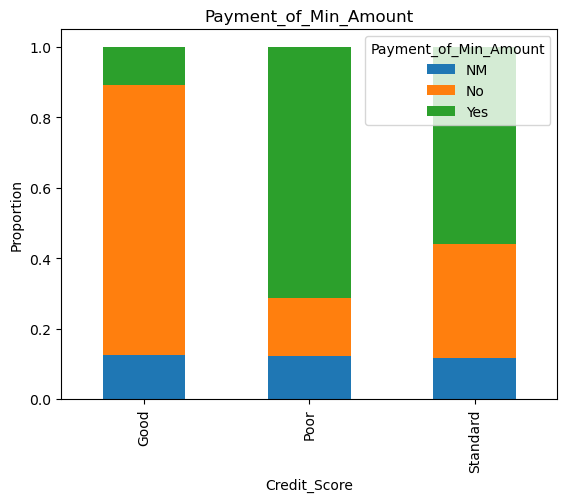

In [12]:
# Create a bar plot for each categorical column by "Credit_Score"
# Iterate over each categorical column and create a bar plot
for col in categorical_cols:
    # Group the DataFrame by 'Credit_Score' and the current categorical column
    grouped = df.groupby(['Credit_Score', col]).size().unstack()
    
    # Normalize the data to convert counts to proportions
    grouped = grouped.div(grouped.sum(axis=1), axis=0)
    
    # Create the bar plot
    grouped.plot(kind='bar', stacked=True)
    plt.title(col)
    plt.xlabel('Credit_Score')
    plt.ylabel('Proportion')
    plt.show()

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
#from sklearn.svm import SVC


# Define the features and label
features = ['Monthly_Inhand_Salary', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Mix', 'Payment_of_Min_Amount']
label = 'Credit_Score'

# Convert the label column to ordinal categories
label_encoder = OrdinalEncoder()
y = label_encoder.fit_transform(df[label].values.reshape(-1, 1))

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.3, random_state=0)

#Categorical and numerical cols
cat_cols = ['Credit_Mix', 'Payment_of_Min_Amount']
num_cols = ['Monthly_Inhand_Salary', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

# Define a pipeline for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define a pipeline for categorical columns
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a ColumnTransformer to apply the pipeline to the numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Fit the preprocessor to the training data and transform both the training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print('Training Set: %d, Test Set: %d \n' % (len(X_train), len(X_test)))

# Print the transformed DataFrame
print("X_train_Transformed /n",X_train_transformed)
print("X_test_Transformed /n",X_test_transformed)


Training Set: 70000, Test Set: 30000 

X_train_Transformed /n [[-9.62948806e-01  1.83819055e-02 -4.77111390e-01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [-4.15967739e-02  0.00000000e+00  1.67810664e+00 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.98216011e+00 -2.99535488e-02 -1.21796759e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 ...
 [-3.83742770e-01 -1.38417307e-02 -1.42001928e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-3.10528121e-16 -4.60653669e-02  2.63744806e-01 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-1.14982457e+00  8.28291779e-02 -4.09760827e-01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
X_test_Transformed /n [[-3.10528121e-16  6.67173598e-02  1.27400326e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [-2.60029570e-01  3.44937236e-02 -4.09760827e-01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [-3.10528121e-16 -2.99535488e-02  2.63744806e-01 ...  0.00000000e+00


#### Model

In [14]:
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.ensemble import AdaBoostClassifier#
#from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score


from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

#mcm = confusion_matrix(y_test, predictions)

#lr_model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000).fit(X_train_transformed, y_train)
#kn_model = KNeighborsClassifier().fit(X_train_transformed, y_train)
#dt_model = DecisionTreeClassifier().fit(X_train_transformed, y_train)
rf_model = RandomForestClassifier().fit(X_train_transformed, y_train)
#nb_model = GaussianNB().fit(X_train_transformed, y_train)
#ab_model = AdaBoostClassifier().fit(X_train_transformed, y_train)
#svc_model = SVC().fit(X_train_transformed,y_train)


#models = [lr_model, kn_model, dt_model, rf_model, ab_model, nb_model]

C:\Users\User\AppData\Local\Temp\ipykernel_7708\1915415554.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = RandomForestClassifier().fit(X_train_transformed, y_train)


In [15]:
def classification_report_func(curr_model):
    print('\n Current model is: \n', curr_model)
    predictions = curr_model.predict(X_test_transformed)

    print('Predicted labels: ', predictions[:15])
    print('Actual labels   : ' ,y_test[:15]) 
    print(classification_report(y_test, predictions))
    
#for model in models:
#    scorer(model)


##### Function for checking scores for each model hidden below.

In [16]:
def scorer(curr_model):
    print('\n Current model is: \n', curr_model)
    predictions = curr_model.predict(X_test_transformed)
    print(curr_model ,"Overall Accuracy:", accuracy_score(y_test, predictions))
    print(curr_model,"Overall Precision:", precision_score(y_test, predictions, average='macro'))
    print(curr_model,"Overall Recall:", recall_score(y_test, predictions, average='macro'))

scorer(rf_model)


 Current model is: 
 RandomForestClassifier()
RandomForestClassifier() Overall Accuracy: 0.7316
RandomForestClassifier() Overall Precision: 0.7072467924409388
RandomForestClassifier() Overall Recall: 0.7188842074813461


##### Conclusion
Random Forest has the best accuracy score score with 0.7225 overall score.


In [17]:
import pickle

# Save the model to a file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

In [18]:
for col in numeric_cols:
    test[col] = test[col].replace('_', '')
    test[col] = pd.to_numeric(test[col], errors='coerce')


test_transformed = preprocessor.fit_transform(test)

In [19]:
import joblib

# Load the saved model
rf_model = joblib.load('random_forest_model.pkl')

# Use the model to predict the target variable for the test data
test_predictions = rf_model.predict(test_transformed)

# Print the predictions
print(test_predictions)


ValueError: X has 17 features, but RandomForestClassifier is expecting 18 features as input.

In [20]:
df.describe().columns

Index(['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance'],
      dtype='object')

In [21]:
test.describe().columns

Index(['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance'],
      dtype='object')

In [ ]:
X_train.describe().columns